### Rough code used to extract letters from the images to feed into the CNN

In [3]:
import pandas as pd
import cv2
import imutils
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import Counter
import re
import swifter
import pickle
from pandarallel import pandarallel
# pandarallel.intialize()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
df = pd.read_csv('data/written_name_train_v2.csv')

In [3]:
df.head(10)
name_cnts = df['IDENTITY'].value_counts()

In [4]:
name_cnts['NONE']

41

In [5]:
df[df['IDENTITY'] == 'NaN']

Empty DataFrame
Columns: [FILENAME, IDENTITY]
Index: []

In [6]:
df = df[df['IDENTITY'].apply(isinstance, args=(str,))]

# Display non-string rows
df.shape

(330396, 2)

In [7]:
df['IDENTITY'] = df['IDENTITY'].str.upper()

In [1]:
counts = Counter(''.join(df['IDENTITY']))


chars = list(counts.keys())
counts_values = list(counts.values())


plt.figure(figsize=(10, 6))
plt.bar(chars, counts_values, color='skyblue', edgecolor='black')


plt.xlabel('Characters', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Character Frequency Histogram', fontsize=16)


plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()


plt.show()


NameError: name 'Counter' is not defined

In [21]:
def crop_top(image_path, pixels_to_crop):
    # Read the image
    image = cv2.imread(image_path)
    plt.imshow(image).squeeze()
    # Get the dimensions of the image
    height, width = image.shape[:2]
    
    # Crop 'pixels_to_crop' from the top
    cropped_image = image[0:height, pixels_to_crop:width]
    
    return cropped_image

In [10]:
def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

In [28]:
# def get_letters(img):
#     letters = []
#     image = crop_top(img, 1)
#     plt.imshow(image)
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     ret,thresh1 = cv2.threshold(gray ,127,255,cv2.THRESH_BINARY_INV)
#     dilated = cv2.dilate(thresh1, None, iterations=2)

#     cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
#     cnts = imutils.grab_contours(cnts)
#     cnts = sort_contours(cnts, method="left-to-right")[0]
#     # loop over the contours
#     for c in cnts:
#         if cv2.contourArea(c) > 10:
#             (x, y, w, h) = cv2.boundingRect(c)
#             cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
#         roi = gray[y:y + h, x:x + w]
#         thresh = cv2.threshold(roi, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
#         thresh = cv2.resize(thresh, (32, 32), interpolation = cv2.INTER_CUBIC)
#         thresh = thresh.astype("float32") / 255.0
#         thresh = np.expand_dims(thresh, axis=-1)
#         thresh = thresh.reshape(1,32,32,1)

#         height, width = roi.shape[:2]
    
#     # Calculate the area (width * height)
#         area = width * height

#         if (height >= 11 and area < 800) or (True):
#             print("Height =", height)
#             print("Area = ", area)
#         # Display each sub-image (letter)
#             plt.figure(figsize=(2, 2))
#             plt.imshow(thresh.squeeze(), cmap='gray')  # squeeze() removes any extra dimensions for display
#             plt.title(f'Letter')
#             plt.axis('off')
#             plt.show()
        
#         # ypred = model.predict(thresh)
#         # ypred = LB.inverse_transform(ypred)
#         # [x] = ypred
#         # letters.append(x)
#     return letters, image


In [29]:
# import cv2
# import numpy as np
# import imutils
# from imutils.contours import sort_contours
# import matplotlib.pyplot as plt

def get_letters(img):
    letters = []
    image = crop_top(img, 0)  # Assuming crop_top is defined elsewhere
    # plt.imshow(image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh1 = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, None, iterations=2)

    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]

    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            
        roi = gray[y:y + h, x:x + w]
        thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

        height, width = roi.shape[:2]
    
    # Calculate the area (width * height)
        area = width * height

        inner_cnts = [c]

        SHOW_ALL = False

        if (height >= 12 and area < 800 and area >= 300) or (SHOW_ALL):
        # Find contours inside this `thresh` to split it further
            inner_cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            inner_cnts = imutils.grab_contours(inner_cnts)
            inner_cnts = sort_contours(inner_cnts, method="left-to-right")[0]  # Sort the inner letters

        
        if (height >= 12 and area < 800) or (SHOW_ALL):    # Loop through each detected inner contour (letter) inside the ROI
            if len(inner_cnts) == 2:
                for ic in inner_cnts:
                    # print("Height =", height, "Area =", area)
                    (ix, iy, iw, ih) = cv2.boundingRect(ic)
                    if iw * ih > 10:  # Filter out noise or very small components
                            # Adjust bounds to ensure they don't go negative or out of bounds
                            pad = 1
                            x1 = max(ix - pad, 0)
                            y1 = max(iy - pad, 0)
                            x2 = min(ix + iw + pad, thresh.shape[1])  # Ensure we don't go beyond the image width
                            y2 = min(iy + ih + pad, thresh.shape[0])  # Ensure we don't go beyond the image height

                            # Extract the region of interest safely
                            letter_roi = thresh[y1:y2, x1:x2]

                            # Check if the roi has a valid size before resizing
                            if letter_roi.size > 0:
                                resized_letter = cv2.resize(letter_roi, (32, 32), interpolation=cv2.INTER_CUBIC)
                                resized_letter = resized_letter.astype("float32") / 255.0
                                resized_letter = np.expand_dims(resized_letter, axis=-1)  # Add channel dimension
                                # Display each letter
                                # plt.figure(figsize=(2, 2))
                                # plt.imshow(resized_letter.squeeze(), cmap='gray')
                                # plt.title(f'Letter')
                                # plt.axis('off')
                                # plt.show()
                                letters.append(resized_letter)

        
            elif len(inner_cnts) == 1:
                # print("Height =", height, end = ", ")
                # print("Area = ", area)
                thresh = cv2.resize(thresh, (32, 32), interpolation = cv2.INTER_CUBIC)
                thresh = thresh.astype("float32") / 255.0
                thresh = np.expand_dims(thresh, axis=-1)
                thresh = thresh.reshape(1,32,32,1)
            # Display each sub-image (letter)
                # plt.figure(figsize=(2, 2))
                # plt.imshow(thresh.squeeze(), cmap='gray')  # squeeze() removes any extra dimensions for display
                # plt.title(f'Letter')
                # plt.axis('off')
                # plt.show()
                letters.append(thresh)

    return letters, image


In [13]:
def get_image_name(num):
    num = str(num)
    img_num = '00000'
    img_name = 'TRAIN_' + img_num[:5-len(num)] + num + '.jpg'
    return img_name

TypeError: Image data of dtype object cannot be converted to float

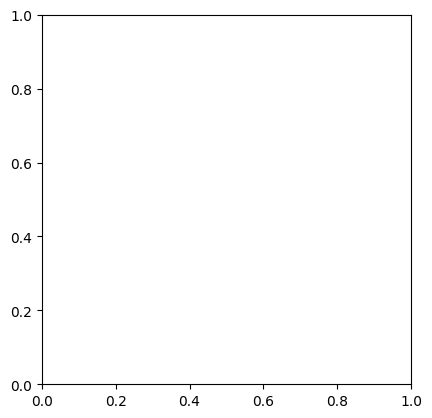

In [ ]:
get_letters(os.path.join('data', 'train_v2', 'train', 'TRAIN_00001.jpg'))

In [14]:
len(df)

330396

In [15]:
df['IDENTITY_alpha'] = df['IDENTITY'].apply(lambda x: re.sub(r'[^a-zA-Z]', '', str(x)))
df['combined'] = df['FILENAME'] + ' ' + df['IDENTITY_alpha']
df.head()

FILENAME   IDENTITY IDENTITY_alpha                   combined
0  TRAIN_00001.jpg  BALTHAZAR      BALTHAZAR  TRAIN_00001.jpg BALTHAZAR
1  TRAIN_00002.jpg      SIMON          SIMON      TRAIN_00002.jpg SIMON
2  TRAIN_00003.jpg      BENES          BENES      TRAIN_00003.jpg BENES
3  TRAIN_00004.jpg    LA LOVE         LALOVE     TRAIN_00004.jpg LALOVE
4  TRAIN_00005.jpg     DAPHNE         DAPHNE     TRAIN_00005.jpg DAPHNE

In [ ]:
# import swifter
def generate_letter_data(combined_string):
    try:
        import pandas as pd
        import cv2
        import imutils
        import matplotlib.pyplot as plt
        import numpy as np
        import os
        from collections import Counter
        import re
        import swifter
        import pickle
        from pandarallel import pandarallel
        # import cv2
# import numpy as np
# import imutils
# from imutils.contours import sort_contours
# import matplotlib.pyplot as plt


        def get_letters(img):
            def crop_top(image_path, pixels_to_crop):
                # Read the image
                image = cv2.imread(image_path)
                # Get the dimensions of the image
                height, width = image.shape[:2]
                
                # Crop 'pixels_to_crop' from the top
                cropped_image = image[0:height, pixels_to_crop:width]
                
                return cropped_image
            def sort_contours(cnts, method="left-to-right"):
                reverse = False
                i = 0
                if method == "right-to-left" or method == "bottom-to-top":
                    reverse = True
                if method == "top-to-bottom" or method == "bottom-to-top":
                    i = 1
                boundingBoxes = [cv2.boundingRect(c) for c in cnts]
                (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                key=lambda b:b[1][i], reverse=reverse))
                # return the list of sorted contours and bounding boxes
                return (cnts, boundingBoxes)
            letters = []
            image = crop_top(img, 3)  # Assuming crop_top is defined elsewhere
            # plt.imshow(image)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            ret, thresh1 = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
            dilated = cv2.dilate(thresh1, None, iterations=2)

            cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cnts = imutils.grab_contours(cnts)
            cnts = sort_contours(cnts, method="left-to-right")[0]

            if len(cnts) == 0:
                return letters, image
            
            for c in cnts:
                if cv2.contourArea(c) > 10:
                    (x, y, w, h) = cv2.boundingRect(c)
                    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
                    
                roi = gray[y:y + h, x:x + w]
                thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

                height, width = roi.shape[:2]
            
            # Calculate the area (width * height)
                area = width * height

                inner_cnts = [c]

                SHOW_ALL = False

                if (height >= 12 and area < 800 and area >= 300) or (SHOW_ALL):
                # Find contours inside this `thresh` to split it further
                    inner_cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                    inner_cnts = imutils.grab_contours(inner_cnts)
                    inner_cnts = sort_contours(inner_cnts, method="left-to-right")[0]  # Sort the inner letters

                
                if (height >= 12 and area < 800) or (SHOW_ALL):    # Loop through each detected inner contour (letter) inside the ROI
                    if len(inner_cnts) == 2:
                        for ic in inner_cnts:
                            # print("Height =", height, "Area =", area)
                            (ix, iy, iw, ih) = cv2.boundingRect(ic)
                            if iw * ih > 10:  # Filter out noise or very small components
                                    # Adjust bounds to ensure they don't go negative or out of bounds
                                    pad = 1
                                    x1 = max(ix - pad, 0)
                                    y1 = max(iy - pad, 0)
                                    x2 = min(ix + iw + pad, thresh.shape[1])  # Ensure we don't go beyond the image width
                                    y2 = min(iy + ih + pad, thresh.shape[0])  # Ensure we don't go beyond the image height

                                    # Extract the region of interest safely
                                    letter_roi = thresh[y1:y2, x1:x2]

                                    # Check if the roi has a valid size before resizing
                                    if letter_roi.size > 0:
                                        resized_letter = cv2.resize(letter_roi, (32, 32), interpolation=cv2.INTER_CUBIC)
                                        resized_letter = resized_letter.astype("float32") / 255.0
                                        resized_letter = np.expand_dims(resized_letter, axis=-1)  # Add channel dimension
                                        # Display each letter
                                        # plt.figure(figsize=(2, 2))
                                        # plt.imshow(resized_letter.squeeze(), cmap='gray')
                                        # plt.title(f'Letter')
                                        # plt.axis('off')
                                        # plt.show()
                                        letters.append(resized_letter)

                
                    elif len(inner_cnts) == 1:
                        # print("Height =", height, end = ", ")
                        # print("Area = ", area)
                        thresh = cv2.resize(thresh, (32, 32), interpolation = cv2.INTER_CUBIC)
                        thresh = thresh.astype("float32") / 255.0
                        thresh = np.expand_dims(thresh, axis=-1)
                        thresh = thresh.reshape(1,32,32,1)
                    # Display each sub-image (letter)
                        # plt.figure(figsize=(2, 2))
                        # plt.imshow(thresh.squeeze(), cmap='gray')  # squeeze() removes any extra dimensions for display
                        # plt.title(f'Letter')
                        # plt.axis('off')
                        # plt.show()
                        letters.append(thresh)

            return letters, image

        # pandarallel.intialize()
        pd.set_option('display.max_rows', None)
        pd.set_option('display.max_columns', None)
        import re
        print(combined_string.split())
        IMG_NAME, name = combined_string.split()
        name = re.sub(r'[^a-zA-Z]', '', name)
        img_path = os.path.join('data','train_v2','train',IMG_NAME)
        # print(img_path)
        # img = cv2.imread(img_path)

        # plt.imshow(img).squeeze()
        # plt.show()
        
        letter,image = get_letters(img_path)
            # word = get_word(letter)
            # print(word)
            # plt.figure(figsize = (10,10))
            # plt.imshow(image)
            # plt.show()
            
            # print(len(letter))
            # print(letter[0])

        ok = False
        for i in range(len(letter)):
            for j in range(len(letter)):
                if np.array_equal(letter[i], letter[j]):
                    if(i != j and len(letter[i]) > 0):
                        ok = True
                        letter[min(i,j)] = []

        if ok:
            letter.remove([])
        
        # if len(name) + 1 == len(letter):
        #     letter.pop(0)

        # print(len(letter))

        # print(name, len(name))

        if len(letter) == len(name):
            for i in range(len(letter)):
                img_name = IMG_NAME[:-4] + '_' + str(i) + '.jpg'
                plt.figure(figsize=(2, 2))
                plt.imshow(letter[i].squeeze(), cmap='gray')  # squeeze() removes any extra dimensions for display
                # plt.title(f'Letter')
                plt.axis('off')
                dir_path = os.path.join('train_letters', name[i])  # Path to the folder
                if not os.path.exists(dir_path):
                    os.makedirs(dir_path)  # Create the folder recursively
                
                # Save the image to the correct path
                path = os.path.join(dir_path, img_name)  # Full path with filename
                plt.savefig(path, bbox_inches = 'tight',pad_inches = 0)
                dir_path = os.path.join(dir_path, 'bin')
                if not os.path.exists(dir_path):
                    os.makedirs(dir_path)  # Create the folder recursively
                pkl_path = os.path.join(dir_path, img_name.replace('.jpg', '.pkl'))  # Save as .pkl file
                with open(pkl_path, 'wb') as f:
                    pickle.dump(letter[i], f)  # Dump the letter (numpy array) to a .pkl file
                # print(f"Saved pickle data to {pkl_path}")
                plt.close()
                # cv2.imwrite(path,letter[i])
                # print(f"Saved to {path}")

    except:
        print("FAIL")
        pass

In [59]:
from pandarallel import pandarallel
import re
pandarallel.initialize()
df['combined'][int(len(df)/2):].parallel_apply(generate_letter_data)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


165497    None
165498    None
165499    None
165500    None
165501    None
165502    None
165503    None
165504    None
165505    None
165506    None
165507    None
165508    None
165509    None
165510    None
165511    None
165512    None
165513    None
165514    None
165515    None
165516    None
165517    None
165518    None
165519    None
165520    None
165521    None
165522    None
165523    None
165524    None
165525    None
165526    None
165527    None
165528    None
165529    None
165530    None
165531    None
165532    None
165533    None
165534    None
165535    None
165536    None
165537    None
165538    None
165539    None
165540    None
165541    None
165542    None
165543    None
165544    None
165545    None
165546    None
165547    None
165548    None
165549    None
165550    None
165551    None
165552    None
165553    None
165554    None
165555    None
165556    None
165557    None
165558    None
165559    None
165560    None
165561    None
165562    None
165563    

1
'AxesImage' object has no attribute 'squeeze'


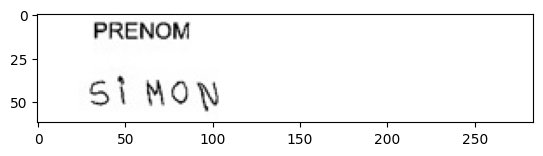

In [ ]:

for i in range(1,2):
    try:
    
        print(i)
        name = df['IDENTITY'][i]
        name = re.sub(r'[^a-zA-Z]', '', name)
        # name.remove
        IMG_NAME = df['FILENAME'][i]
        img_path = os.path.join('data','train_v2','train',IMG_NAME)
        
        # print(img_path)
        letter,image = get_letters(img_path)
        print(letter)
        # word = get_word(letter)
        # print(word)
        # plt.figure(figsize = (10,10))
        # plt.imshow(image)
        # plt.show()
        
        # print(len(letter))
        # print(letter[0])

        ok = False
        for i in range(len(letter)):
            for j in range(len(letter)):
                if np.array_equal(letter[i], letter[j]):
                    if(i != j and len(letter[i]) > 0):
                        ok = True
                        letter[min(i,j)] = []

        if ok:
            letter.remove([])
        
        # if len(name) + 1 == len(letter):
        #     letter.pop(0)

        # print(len(letter))

        # print(name, len(name))
        if len(letter) == len(name):
            for i in range(len(letter)):
                img_name = IMG_NAME[:-4] + '_' + str(i) + '.jpg'
                plt.figure(figsize=(2, 2))
                plt.imshow(letter[i].squeeze(), cmap='gray')  # squeeze() removes any extra dimensions for display
                # plt.title(f'Letter')
                plt.axis('off')
                dir_path = os.path.join('train_letters', name[i])  # Path to the folder
                if not os.path.exists(dir_path):
                    os.makedirs(dir_path)  # Create the folder recursively
                
                # Save the image to the correct path
                path = os.path.join(dir_path, img_name)  # Full path with filename
                plt.savefig(path, bbox_inches = 'tight',pad_inches = 0)
                dir_path = os.path.join(dir_path, 'bin')
                if not os.path.exists(dir_path):
                    os.makedirs(dir_path)  # Create the folder recursively
                pkl_path = os.path.join(dir_path, img_name.replace('.jpg', '.pkl'))  # Save as .pkl file
                with open(pkl_path, 'wb') as f:
                    pickle.dump(letter[i], f)  # Dump the letter (numpy array) to a .pkl file
                # print(f"Saved pickle data to {pkl_path}")
                plt.close()
                # cv2.imwrite(path,letter[i])
                # print(f"Saved to {path}")

    except Exception as poo:
        print(poo)
        continue
    # if len(name) == len(letter):
    #     for i in range(len(name)):
    #         cv2.imwrite(os.path.join('letter', ''), letter[i])

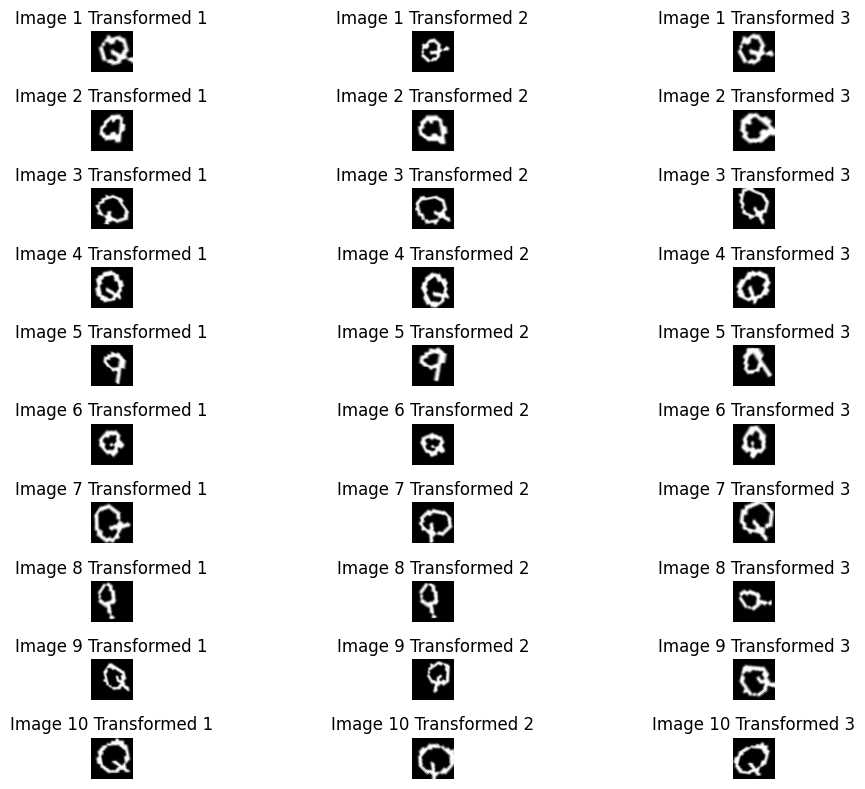

In [30]:
import os
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# Load the first 10 images of the letter 'A'
letter = 'Q'
letter_path = os.path.join('train_letters', letter)
images_bin = os.listdir(letter_path)[1:11]  # Get first 10 images

# Define transformations
transform = transforms.Compose([
    transforms.RandomAffine(degrees=60, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create a figure for displaying the images
plt.figure(figsize=(12, 8))

# Loop through the first 10 images
for i, image_file in enumerate(images_bin):
    image_path = os.path.join(letter_path, image_file)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Convert the grayscale image to PIL format for PyTorch transformations
    image_pil = Image.fromarray(image)

    # Generate and display 3 transformed images for each original image
    for j in range(3):
        transformed_image = transform(image_pil)

        # Display the transformed image
        plt.subplot(10, 3, i * 3 + j + 1)
        plt.imshow(transformed_image.squeeze(), cmap='gray')
        plt.title(f"Image {i+1} Transformed {j+1}")
        plt.axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [19]:
import os
import cv2
import random
from torchvision import transforms
from PIL import Image
from tqdm import tqdm  # for progress bar
import numpy as np

# Define transformations
transform = transforms.Compose([
    transforms.RandomAffine(degrees=60, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Define path for dataset
base_path = 'train_letters'

# Loop through each letter from A to Z
for letter in 'ABCDEFGHIJKLMNOPQRSTUVWXYZ':
    letter_path = os.path.join(base_path, letter)
    train_set_path = os.path.join(letter_path, 'train_set')
    os.makedirs(train_set_path, exist_ok=True)

    # Load all available images for the current letter
    images_bin = os.listdir(letter_path)
    image_count = len(images_bin)

    # Set a target of 10,000 images
    target_count = 10000

    # If the letter has fewer than 10,000 images, we will augment to reach 10,000
    total_images_needed = max(image_count, target_count)

    print(f"Processing letter '{letter}' with {image_count} images. Target: {total_images_needed} images.")

    # If we have more than 10,000 images, randomly sample 10,000 images
    if image_count > target_count:
        continue
        images_bin = random.sample(images_bin, target_count)
        image_count = target_count  # update count to target after sampling

    current_image_num = 0
    for image_file in tqdm(images_bin, desc=f"Processing '{letter}' images"):
        image_path = os.path.join(letter_path, image_file)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            continue  # skip if image loading failed
        
        # image_pil = Image.fromarray(image)

        if image_count < target_count:
            # Generate 3 augmented images per original if we're upsampling
            for _ in range(3):
                # transformed_image = transform(image_pil)
                # transformed_image_pil = transforms.ToPILImage()(transformed_image)
                transformed_image_pil.save(os.path.join(train_set_path, f"{letter}_{current_image_num}.png"))
                current_image_num += 1
                if current_image_num >= target_count:
                    break
        else:
            # If we have enough images, directly copy the sampled image
            image_pil.save(os.path.join(train_set_path, f"{letter}_{current_image_num}.png"))
            current_image_num += 1

        # Break the loop once we reach the target count
        if current_image_num >= target_count:
            break

    print(f"Completed letter '{letter}' with {current_image_num} images.")


Processing letter 'A' with 172086 images. Target: 172086 images.
Processing letter 'B' with 27210 images. Target: 27210 images.
Processing letter 'C' with 41731 images. Target: 41731 images.
Processing letter 'D' with 36314 images. Target: 36314 images.
Processing letter 'E' with 164155 images. Target: 164155 images.
Processing letter 'F' with 11101 images. Target: 11101 images.
Processing letter 'G' with 23791 images. Target: 23791 images.
Processing letter 'H' with 38525 images. Target: 38525 images.
Processing letter 'I' with 98827 images. Target: 98827 images.
Processing letter 'J' with 9537 images. Target: 10000 images.


Processing 'J' images:   0%|          | 1/9537 [00:00<23:23,  6.80it/s]


NameError: name 'transformed_image_pil' is not defined

In [36]:
import os
import shutil

def delete_folder_contents_if_few_items(folder_path, threshold=10000):
    # Check if the folder exists
    if not os.path.exists(folder_path):
        print("Folder does not exist.")
        return

    # Count the items in the folder
    item_count = len(os.listdir(folder_path))

    folder_path = os.path.join(folder_path, 'train_set')

    # Delete contents if item count is below the threshold
    if item_count < threshold:
        for item in os.listdir(folder_path):
            item_path = os.path.join(folder_path, item)
            try:
                # Remove file or folder
                if os.path.isfile(item_path) or os.path.islink(item_path):
                    os.remove(item_path)
                elif os.path.isdir(item_path):
                    shutil.rmtree(item_path)
            except Exception as e:
                print(f"Failed to delete {item_path}. Reason: {e}")
        print(f"All contents in '{folder_path}' have been deleted.")
    else:
        print(f"Folder '{folder_path}' has {item_count} items, no deletion performed.")

# Example usage
base_path = 'train_letters'
for letter in 'ABCDEFGHIJKLMNOPQRSTUVWXYZ':
    folder_path = os.path.join(base_path, letter)
    delete_folder_contents_if_few_items(folder_path)


Folder 'train_letters\A\train_set' has 172086 items, no deletion performed.
Folder 'train_letters\B\train_set' has 27210 items, no deletion performed.
Folder 'train_letters\C\train_set' has 41731 items, no deletion performed.
Folder 'train_letters\D\train_set' has 36314 items, no deletion performed.
Folder 'train_letters\E\train_set' has 164155 items, no deletion performed.
Folder 'train_letters\F\train_set' has 11101 items, no deletion performed.
Folder 'train_letters\G\train_set' has 23791 items, no deletion performed.
Folder 'train_letters\H\train_set' has 38525 items, no deletion performed.
Folder 'train_letters\I\train_set' has 98827 items, no deletion performed.
All contents in 'train_letters\J\train_set' have been deleted.
All contents in 'train_letters\K\train_set' have been deleted.
Folder 'train_letters\L\train_set' has 100444 items, no deletion performed.
Folder 'train_letters\M\train_set' has 51679 items, no deletion performed.
Folder 'train_letters\N\train_set' has 103274 

In [55]:
import os
import shutil
import random

def pad_folder_to_10k_items(folder_path, letter, target_count=10000):
    # Get the list of items in the folder
    items = os.listdir(folder_path)
    item_count = len(items)
    train_set_path = os.path.join(folder_path, 'train_set')
    train_set_item_count = len(os.listdir(train_set_path))
    print(train_set_item_count)
    # If the folder has 10,000 or more items, no need to add more
    if train_set_item_count >= target_count:
        print(f"Folder already has {train_set_item_count} items. No additional files needed.")
        return
    
    items_ = random.sample(items, min(10000, item_count))
    cnt = train_set_item_count+1
    # for i in range(len(items_)):
    #     sample_item = items_[i]
    #     sample_path = os.path.join(folder_path, sample_item)

    #     # Define a new file name to avboid overwriting
    #     new_item_name = f"{letter}_{cnt}.png"
    #     cnt += 1
    #     new_item_path = os.path.join(train_set_path, new_item_name)

    #     # Copy the file or directory
    #     if os.path.isfile(sample_path):
    #         shutil.copy2(sample_path, new_item_path)
    #     elif os.path.isdir(sample_path):
    #         # shutil.copytree(sample_path, new_item_path)
    #         continue

    item_count = len(items_)
    train_set_item_count = len(os.listdir(train_set_path))
    items_to_add = target_count - train_set_item_count
    print(f"Folder has {item_count} items. Adding {items_to_add} items to reach {target_count}.")

    if items_to_add < 100:
        return

    # Sample items with replacement to add up to target count
    for i in range(items_to_add):
        # Randomly choose an existing item to copy
        sample_item = random.choice(items)
        sample_path = os.path.join(folder_path, sample_item)
        
        # Define a new file name to avoid overwriting
        new_item_name = f"{letter}_{cnt}.png"
        cnt += 1
        new_item_path = os.path.join(folder_path, 'train_set', new_item_name)

        # Copy the file or directory
        if os.path.isfile(sample_path):
            shutil.copy2(sample_path, new_item_path)
        elif os.path.isdir(sample_path):
            continue
            
    print(f"Folder '{folder_path}' now has {target_count} items.")

# Example usage

base_path = 'train_letters'
for letter in 'ABCDEFGHIJKLMNOPQRSTUVWXYZ':
    folder_path = os.path.join(base_path,  letter)
    print(folder_path)
    pad_folder_to_10k_items(folder_path, letter)


train_letters\A
10000
Folder already has 10000 items. No additional files needed.
train_letters\B
10000
Folder already has 10000 items. No additional files needed.
train_letters\C
10000
Folder already has 10000 items. No additional files needed.
train_letters\D
10000
Folder already has 10000 items. No additional files needed.
train_letters\E
10000
Folder already has 10000 items. No additional files needed.
train_letters\F
10348
Folder already has 10348 items. No additional files needed.
train_letters\G
10732
Folder already has 10732 items. No additional files needed.
train_letters\H
10000
Folder already has 10000 items. No additional files needed.
train_letters\I
10000
Folder already has 10000 items. No additional files needed.
train_letters\J
19534
Folder already has 19534 items. No additional files needed.
train_letters\K
13040
Folder already has 13040 items. No additional files needed.
train_letters\L
13289
Folder already has 13289 items. No additional files needed.
train_letters\M


In [13]:
import os
from PIL import Image
base_path = 'train_letters'

X = []
y = []


for letter in 'ABCDEFGHIJKLMNOPQRSTUVWXYZ':
    cnt = 0
    train_set_path = os.path.join(base_path, letter, 'train_set', 'resized')
    for img_name in os.listdir(train_set_path):
        img_path = os.path.join(train_set_path, img_name)
        img = Image.open(img_path).convert("L")
        
        cnt += 1
        if cnt % 100 == 0:
            print(letter, cnt)
        # resized_img = img.resize((28,28))
        # save_path = os.path.join(train_set_path, 'resized', img_name)
        # os.makedirs(os.path.dirname(save_path), exist_ok=True)
        # resized_img.save(save_path)
        img_array = np.array(img).astype('float32')
        img_array /= 255
        print(letter)
        print(img_array)
        break
        # print(img_array.shape)
        X.append(img_array)
        y.append(ord(letter) - ord('A'))
    break

X = np.array(X)
y = np.array(y)

A
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.00392157 0.
  0.         0.         0.         0.         0.         0.
  0.         0.00392157 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.00392157 0.00784314
  0.         0.         0.         0.         0.         0.
  0.         0.00392157 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.00392157 0.00392157 0.         0.         0.
  0.09803922 0.2627451  0.38431373 0.41568628 0.32941177 0.17254902
  0.02745098 0.         0.         0.         0.00392157 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.00392157 0.00392157 0.01176471 0.03529412 0.14

In [ ]:
import os
import numpy as np
from PIL import Image
import multiprocessing as mp

base_path = 'train_letters'

def process_image(img_path, letter):
    """Process a single image: open, convert to grayscale, normalize, and convert to numpy array."""
    img = Image.open(img_path).convert("L")
    img_array = np.array(img).astype('float32') / 255  # Normalize the image
    label = ord(letter) - ord('A')
    return img_array, label

def process_letter_images(letter):
    """Process all images for a given letter and return arrays."""
    letter_X, letter_y = [], []
    train_set_path = os.path.join(base_path, letter, 'train_set', 'resized')
    for cnt, img_name in enumerate(os.listdir(train_set_path), start=1):
        img_path = os.path.join(train_set_path, img_name)
        img_array, label = process_image(img_path, letter)
        letter_X.append(img_array)
        letter_y.append(label)
        if cnt % 100 == 0:
            print(f"{letter} processed {cnt} images")
    return letter_X, letter_y

def main():
    with mp.Pool() as pool:
        # Process each letter's images in parallel
        results = pool.map(process_letter_images, 'ABCDEFGHIJKLMNOPQRSTUVWXYZ')

    # Combine results from all processes
    X = [img_array for letter_X, _ in results for img_array in letter_X]
    y = [label for _, letter_y in results for label in letter_y]

    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)

    return X, y

# Run the parallel processing
X, y = main()


In [5]:
import torch

# Assuming X is a numpy array
train_images_number = X.shape[0]
train_images_height = 28
train_images_width = 28

# Reshape and convert to PyTorch tensor with the correct shape
X = X.reshape(train_images_number, 1, train_images_height, train_images_width)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)


In [3]:
import pickle

with open(f'X_{int(X.shape[0]/26)}.pkl', 'wb') as file:
    pickle.dump(X, file)
    
with open(f'y_{int(y.shape[0]/26)}.pkl', 'wb') as file:
    pickle.dump(y, file)

# for x in X:
#     with open(f'X_{int(X.shape[0]/26)}_1.pkl', 'ab') as file:
#         pickle.dump(x, file)

# for label in y:
#     with open(f'y_{int(X.shape[0]/26)}_1.pkl', 'ab') as file:
#         pickle.dump(label, file)

In [6]:
from joblib import dump
dump(X, f'X_{int(X.shape[0]/26)}.joblib')
dump(y, f'y_{int(X.shape[0]/26)}.joblib')


ValueError: I/O operation on closed file.